# Template for Run Analysis
## Run Details:
- Dataset: 
- Test Goals: 
- Results Summary: 

In [1]:
import sys
import os
import h5py
from collections import Counter
from progressbar import *
import re
import numpy as np
import itertools
from tqdm import tqdm
from repeating_classifier_training_utils import *

par_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

if par_dir not in sys.path:
    sys.path.append(par_dir)
%load_ext autoreload
%matplotlib inline
%autoreload 2

In [2]:
# HTML('''<script>
# code_show=true; 
# function code_toggle() {
#  if (code_show){
#  $('div.input').hide();
#  } else {
#  $('div.input').show();
#  }
#  code_show = !code_show
# } 
# $( document ).ready(code_toggle);
# </script>
# The raw code for this IPython notebook is by default hidden for easier reading.
# To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

## Set Run Directories Here

In [3]:
dump_dir = '/home/cmacdonald/CNN/dumps/'

path_1 = os.path.join(dump_dir,'20200717_183009_no_muons')
path_2 = os.path.join(dump_dir,'20200720_135853_no_muons_lr00002')
preferred_run_idx = 0
paths = list([path_1, path_2])
run_names=['LR1e-4, BS 512','LR2e-5, BS 512']
cut_names=[['fq_failed', 'fq_flag'] for _ in range(2)]

idx_file_paths = ['/fast_scratch/WatChMaL/data/IWCD_fulltank_300_pe_idxs_no_muons.npz' for _ in range(2)]

fq_dset='vetoed'

npz_path = os.path.join(os.getcwd(),'Index_Storage')

LABEL_DICT = {0:"gamma", 1:"e", 2:"mu"}
softmax_index_dict = {value:key for key, value in LABEL_DICT.items()}

## Plot Training History

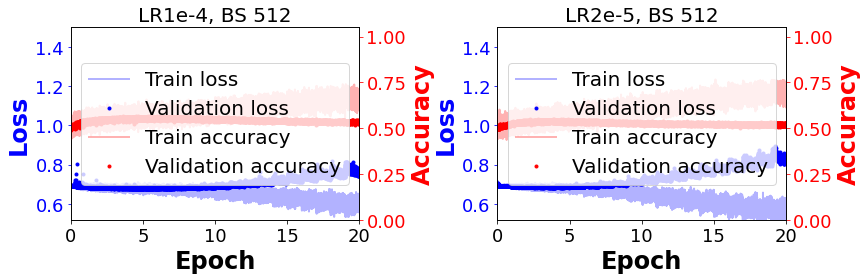

In [4]:
fig = disp_multiple_learn_hist(paths,losslim=1.5,titles=run_names,leg_font=20, title_font=20)

## Plot Confusion Matrices

In [5]:
test_output = [load_test_output_pn(os.path.join(loc,'test_validation_iteration_dump.npz'),os.path.join(os.getcwd(),'Pointnet_Cut_Indices/pointnet_cut_indices.npz'),np.load(idx_file_paths[i])['test_idxs'], cut_names[i]) 
               for i,loc in enumerate(paths)]

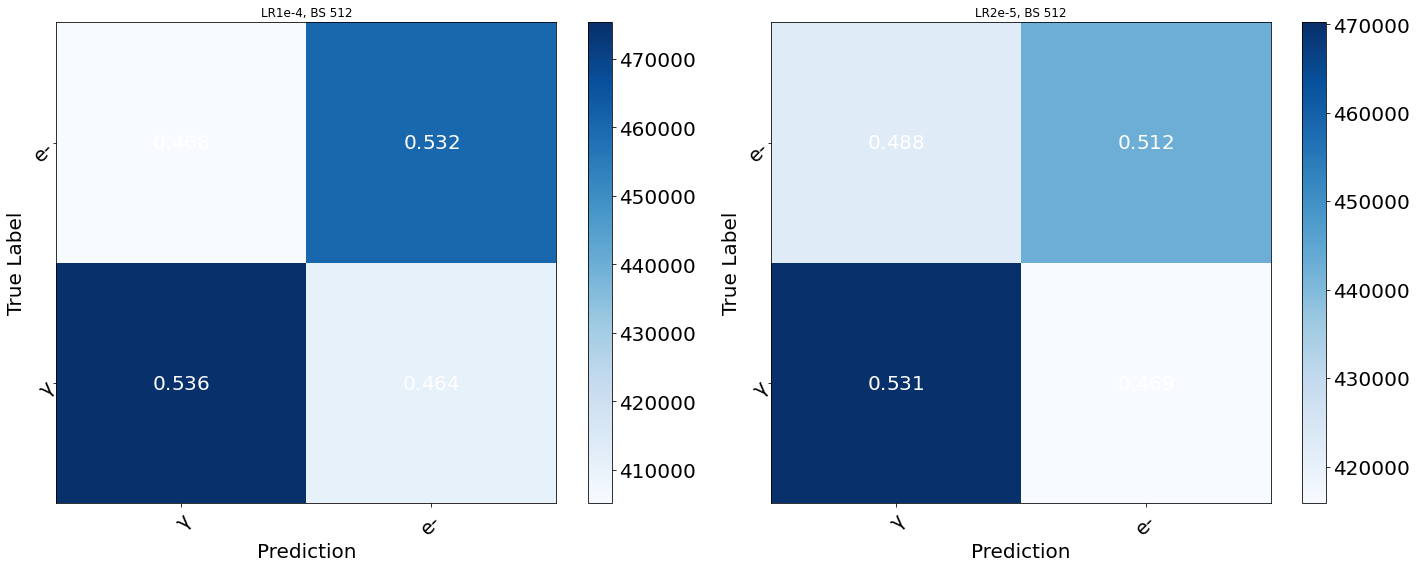

In [6]:
fig = plot_multiple_confusion_matrix([output['labels'] for output in test_output], [output['predicted_labels'] for output in test_output],
                               ['\u03B3','e-'],titles=run_names)

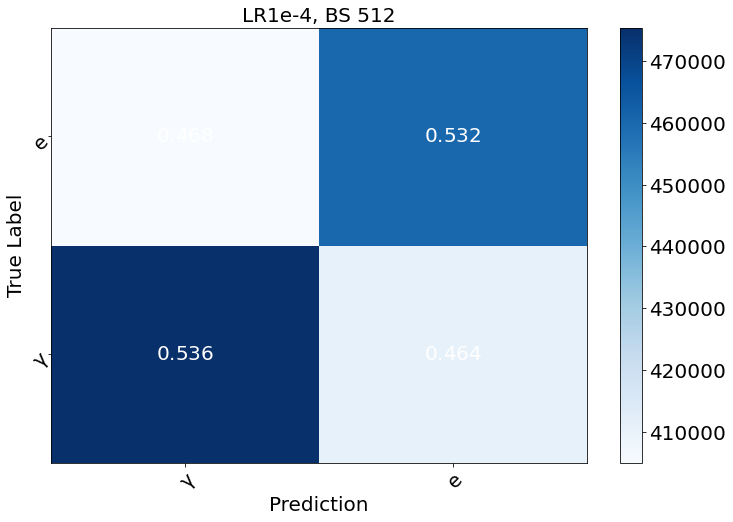

In [7]:
preferred_run=test_output[preferred_run_idx]
plot_confusion_matrix(preferred_run['labels'],preferred_run['predicted_labels'],['\u03B3','e'],title=run_names[preferred_run_idx])


## ROC Curves

In [12]:
fprs, tprs, thresholds = zip(*[prep_roc_data(output['softmax'],output['labels'],
                                'rejection',softmax_index_dict,"e","gamma",energies=output['energies'],) for output in test_output]
                            )

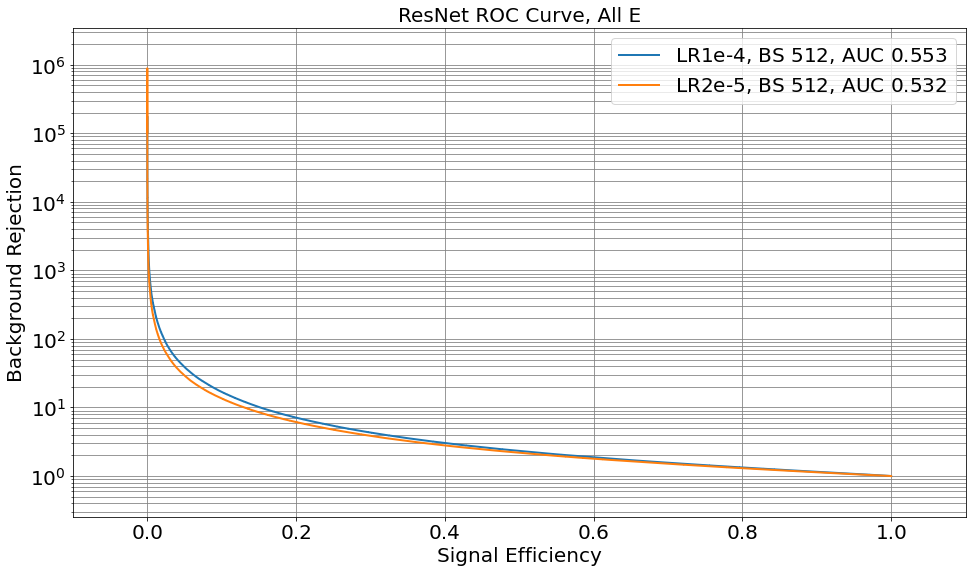

In [13]:
roc_metrics = plot_multiple_ROC((fprs, tprs, thresholds),'rejection', ["e", "gamma"], 
                                plot_labels=run_names,
                                png_name = 'overlaid_roc',title='ResNet ROC Curve, All E',annotate=False)

In [14]:
# Load the fiTQun results

# File paths for fiTQun results
fiTQun_e_path = "/fast_scratch/WatChMaL/data/IWCDmPMT_4pi_fulltank_fiTQun_e-.npz"
fiTQun_mu_path = "/fast_scratch/WatChMaL/data/IWCDmPMT_4pi_fulltank_fiTQun_mu-.npz"
fiTQun_gamma_path = "/fast_scratch/WatChMaL/data/IWCDmPMT_4pi_fulltank_fiTQun_gamma.npz"

# Load fiTQun results
f_e = np.load(fiTQun_e_path, allow_pickle=True)
f_mu = np.load(fiTQun_mu_path, allow_pickle=True)
f_gamma = np.load(fiTQun_gamma_path, allow_pickle=True)

fq_filename_original = (f_gamma['filename'],f_e['filename'],f_mu['filename'])
fq_eventids_original = ( f_gamma['eventid'],f_e['eventid'], f_mu['eventid'])
fq_flag_original = (f_gamma['flag'] ,f_e['flag'],f_mu['flag'])
fq_nll_original = (f_gamma['nLL'],f_e['nLL'],f_mu['nLL'])
fq_mom_original = (f_gamma['momentum'],f_e['momentum'],f_mu['momentum'])

n_events = int(reduce(lambda x,y : x+y, list(map(lambda x : x.shape[0],fq_filename_original))))

fq_rootfiles = np.empty(n_events,dtype=object)
fq_eventids = np.zeros(n_events)
fq_flag = np.empty((n_events,2))
fq_nll = np.empty((n_events,2))
fq_mom = np.empty((n_events, 2))

fq_mapping_indices = np.load(os.path.join(npz_path,'fq_mapping_idxs.npz'),allow_pickle=True)['arr_0']

filtered_indices = np.load("/fast_scratch/WatChMaL/data/IWCD_fulltank_300_pe_idxs.npz", allow_pickle=True)
test_filtered_indices = filtered_indices['test_idxs']
f = h5py.File("/data/WatChMaL/data/IWCDmPMT_4pi_fulltank_9M.h5", "r")

original_eventids = np.array(f['event_ids'])
original_rootfiles = np.array(f['root_files'])
filtered_eventids = original_eventids[test_filtered_indices]
filtered_rootfiles = original_rootfiles[test_filtered_indices]
original_labels = np.array(f['labels'])
labels = original_labels[test_filtered_indices]
fq_failed_idxs = np.load(os.path.join(npz_path,'fq_failed_idxs.npz'), allow_pickle = True)['failed_indices_pointing_to_h5_test_set'].astype(int)
slabels = np.delete(labels, fq_failed_idxs)
sfiltered_eventids = np.delete(filtered_eventids, fq_failed_idxs).astype(int)
sfiltered_rootfiles = np.delete(filtered_rootfiles , fq_failed_idxs)

pbar = ProgressBar(widgets=['Arranging FiTQun Data. Progress: ', Percentage(), ' ', Bar(marker='0',left='[',right=']'),
           ' ', ETA()], maxval=n_events)
pbar.start()
for i,ptype in enumerate(slabels):
    fq_rootfiles[i] = str(fq_filename_original[ptype][fq_mapping_indices[i]])
    fq_eventids[i] = fq_eventids_original[ptype][fq_mapping_indices[i]]
    fq_flag[i] = fq_flag_original[ptype][fq_mapping_indices[i]]
    fq_nll[i] = fq_nll_original[ptype][fq_mapping_indices[i]]
    fq_mom[i] = fq_mom_original[ptype][fq_mapping_indices[i]]
    pbar.update(i)
fq_scores = np.zeros((fq_nll.shape[0],3))
fq_scores[:,0] = fq_nll[:,1] - fq_nll[:,0]
fq_scores[:,1] = fq_nll[:,1] - fq_nll[:,0]
fq_scores[:,2] = fq_nll[:,0] - fq_nll[:,1]
fq_labels = slabels
pbar.finish()

pbar = ProgressBar(widgets=['Verification Progress: ', Percentage(), ' ', Bar(marker='0',left='[',right=']'),
           ' ', ETA()], maxval=len(sfiltered_rootfiles))
pbar.start()
for i in range(len(sfiltered_rootfiles)):
    assert re.sub('_fiTQun','',fq_rootfiles[i].split('/')[-1]) == sfiltered_rootfiles[i].split('/')[-1], print(fq_rootfiles[i])
    assert fq_eventids[i] -1 == sfiltered_eventids[i]
    pbar.update(i)
pbar.finish()
assert len(sfiltered_rootfiles) == fq_rootfiles.shape[0]
print("Success! We now have a FiTQun output set in the same order as the h5 test set")

fq_scores_wflagged = fq_scores
fq_labels_wflagged = fq_labels

flagged_idxs = np.load(os.path.join(npz_path, 'fq_flagged_idxs.npz'))['arr_0']
fq_rootfiles = np.delete(fq_rootfiles, flagged_idxs)
fq_eventids = np.delete(fq_eventids, flagged_idxs)
fq_flag = np.delete(fq_flag, flagged_idxs,0)
fq_nll = np.delete(fq_nll, flagged_idxs,0)
fq_scores = np.delete(fq_scores, flagged_idxs,0)
fq_labels = np.delete(fq_labels, flagged_idxs)
fq_mom = np.delete(fq_mom, flagged_idxs, 0)

if fq_dset=='vetoed':
    failed_idxs = np.load(os.path.join(npz_path, 'fq_failed_idxs.npz'))['failed_indices_pointing_to_h5_test_set']
    odveto = np.array(h5py.File('/fast_scratch/WatChMaL/data/IWCDmPMT_4pm_full_tank_ODveto.h5','r')['veto'])
    odveto_mapping_idxs = np.load(os.path.join(os.getcwd(), 'Index_Storage/od_veto_mapping_idxs.npz'))['mapping_idxs_full_set'].astype(int)    
    odveto_mapping_idxs = np.delete(odveto_mapping_idxs, failed_idxs)
    odveto_mapping_idxs = np.delete(odveto_mapping_idxs, flagged_idxs)
    
    odveto=odveto[odveto_mapping_idxs]
    
    assert odveto.shape[0] == fq_rootfiles.shape[0]
    vetoed_idxs = np.where(odveto==1)[0]
    
    fq_rootfiles = np.delete(fq_rootfiles, vetoed_idxs)
    fq_eventids = np.delete(fq_eventids, vetoed_idxs)
    fq_flag = np.delete(fq_flag, vetoed_idxs,0)
    fq_nll = np.delete(fq_nll, vetoed_idxs,0)
    fq_scores = np.delete(fq_scores, vetoed_idxs,0)
    fq_labels = np.delete(fq_labels, vetoed_idxs)
    fq_mom = np.delete(fq_mom, vetoed_idxs, 0)

Arranging FiTQun Data. Progress: 100% [0000000000000000000000000] Time: 0:00:20
Verification Progress: 100% [00000000000000000000000000000000000] Time: 0:00:21


Success! We now have a FiTQun output set in the same order as the h5 test set


/home/cmacdonald/.local/lib/python3.6/site-packages/ipykernel_launcher.py:88: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


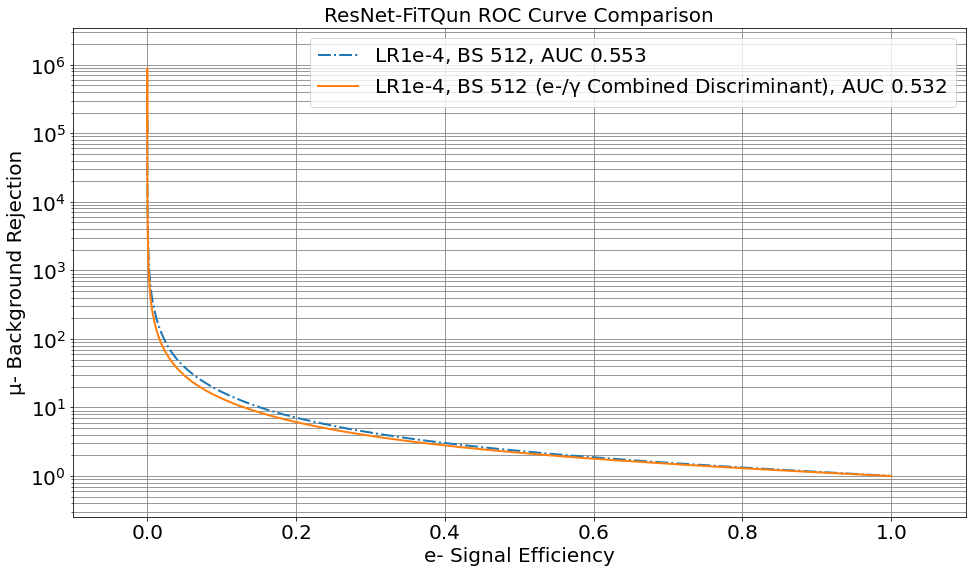

In [15]:
roc_metrics = plot_multiple_ROC((fprs, tprs, thresholds),'rejection', [["e", "gamma"],['e','gamma'],['e','gamma']], 
                                plot_labels = [f'{run_names[preferred_run_idx]}', f'{run_names[preferred_run_idx]} (e-/\u03B3 Combined Discriminant)','FiTQun'],
                                png_name = 'overlaid_roc',title='ResNet-FiTQun ROC Curve Comparison',annotate=False,
                                linestyle=('dashdot','-','--'), xlabel='e- Signal Efficiency',ylabel='\u03BC- Background Rejection')
# plt.savefig(os.path.join(os.getcwd(),'plot_images/ROC_comparison.pdf'))

In [ ]:
fractions, tprs, fprs, thresholds = zip(*[prep_roc_data(preferred_run['softmax'],preferred_run['labels'],
                                'fraction',softmax_index_dict,"e","mu"),
                                prep_roc_data(preferred_run['softmax'],preferred_run['labels'],
                                'fraction',softmax_index_dict,"e","gamma"),
                                prep_roc_data(collapsed_sm_1,collapsed_labels_1, 'fraction',
                                              softmax_index_dict, "e","mu")],
                                prep_roc_data(fq_scores,fq_labels,'fraction',softmax_index_dict,"e","mu")
                            )

In [ ]:
roc_metrics = plot_multiple_ROC((fractions, tprs, fprs, thresholds),'fraction', [["e", "mu"],['e','gamma'],['e','mu'],['e','mu']], 
                                plot_labels = ['e Eff. vs Muon Rej.', 'e Eff. vs Gamma Rej.', 'e/Gamma Eff. vs Muon Rej. \n (e/mu events)','FiTQun e Eff. vs Muon Rej.'],
                                png_name = 'overlaid_roc',title='Repeat Run ROC Curves',annotate=False,linestyle=(':','-','--','dashdot'),
                                leg_loc='lower left')
plt.savefig(os.path.join(os.getcwd(),'plot_images/ROC_comparison_fraction.pdf'))

## Signal Purity vs Energy At Fixed Efficiency

In [16]:
GAMMA_THRESHOLD = 1.55
ELECTRON_THRESHOLD = 0.775
MUON_THRESHOLD = 160.26
shifted_energies = []

shifted_energies = np.zeros(preferred_run['labels'].shape[0])
g_idxs = np.where(preferred_run['labels']==0)[0]
e_idxs = np.where(preferred_run['labels']==1)[0]
m_idxs = np.where(preferred_run['labels']==2)[0]
shifted_energies[g_idxs] = np.squeeze(preferred_run['energies'][g_idxs] - GAMMA_THRESHOLD)
shifted_energies[e_idxs] = np.squeeze(preferred_run['energies'][e_idxs] - ELECTRON_THRESHOLD)
shifted_energies[m_idxs] = np.squeeze(preferred_run['energies'][m_idxs] - MUON_THRESHOLD)

In [ ]:
##Binning in Energy
scores = [fq_scores, preferred_run['softmax'], fq_scores, collapsed_sm, fq_scores, collapsed_sm, -fq_scores, preferred_run['softmax']]
labels = [fq_labels for _ in range(len(scores))]
binning_features = [shifted_energies,shifted_energies,np.clip(fq_mom[:,0], 0, 1000),shifted_energies]
feature_labels = ['Energy above Cherenkov Threshold (MeV)', 'Energy above Cherenkov Threshold (MeV)','FiTQun Reconstructed Electron Momentum (MeV)','Energy above Cherenkov Threshold (MeV)']
title_notes = ['',', Combined ResNet Discriminant',', Combined ResNet Discriminant','']
pos_labels = ['e','e','e','e']
neg_labels = ['mu','mu','mu','gamma']
img_names=['rejection_vs_e.pdf','rejection_vs_e_combined_disc.pdf', 'rejection_vs_recon_e_combined_disc.pdf', 'e_gamma_rejection_vs_e.pdf']
for i in range(len(pos_labels)):
    fig, ax = plt.subplots(figsize=(12,6))
    plot_binned_performance(scores[2*i],
            labels[2*i],
            binning_features[i],           
            feature_labels[i],
            0.8, 30, softmax_index_dict, pos_labels[i],neg_labels[i],metric='rejection',marker='*-',color='r',ax=ax )
    plot_binned_performance(scores[2*i+1],
            labels[2*i+1],
            binning_features[i],           
            feature_labels[i],
            0.8, 30, softmax_index_dict, pos_labels[i],neg_labels[i],metric='rejection',marker='o--',color='b',ax=ax,title_note=title_notes[i] )    
    ax.legend(['FiTQun nLL Diff.','ResNet'],fontsize=14)

In [ ]:
#Binning in d-to-wall
d_to_wall_incl_all = np.load('dist_to_wall.npz', allow_pickle=True)['test_d_to_wall']
fq_failed_idxs = np.load('Index_Storage/fq_failed_idxs.npz', allow_pickle=True)['failed_indices_pointing_to_h5_test_set']
fq_flagged_idxs = np.load('Index_Storage/fq_flagged_idxs.npz', allow_pickle=True)['arr_0']
d_to_wall_incl_flagged = np.delete(d_to_wall_incl_all, fq_failed_idxs)
d_to_wall = np.delete(d_to_wall_incl_flagged, fq_flagged_idxs)
if fq_dset=='vetoed':d_to_wall = np.delete(d_to_wall, vetoed_idxs)

scores = [fq_scores, preferred_run['softmax'], fq_scores, collapsed_sm, fq_scores, preferred_run['softmax'] ]
labels = [fq_labels for _ in range(len(scores))]
binning_features = [d_to_wall,d_to_wall,d_to_wall]
feature_labels = ['Distance to Wall Along Particle Trajectory (cm)','Distance to Wall Along Particle Trajectory (cm)','Distance to Wall Along Particle Trajectory (cm)']
title_notes = [None,', Combined ResNet Discriminant','']
pos_labels = ['e','e','gamma']
neg_labels = ['mu','mu','e']
img_names=['rejection_vs_dtowall.pdf','rejection_vs_dtowall_combined_disc.pdf', 'e_gamma_rejection_vs_dtowall.pdf']
for i in range(len(pos_labels)):
    fig, ax = plt.subplots(figsize=(12,6))
    plot_binned_performance(scores[2*i],
            labels[2*i],
            binning_features[i],           
            feature_labels[i],
            0.8, 30, softmax_index_dict, pos_labels[i],neg_labels[i],metric='rejection',marker='*-',color='r',ax=ax )
    plot_binned_performance(scores[2*i+1],
            labels[2*i+1],
            binning_features[i],           
            feature_labels[i],
            0.8, 30, softmax_index_dict, pos_labels[i],neg_labels[i],metric='rejection',marker='o--',color='b',ax=ax,title_note=title_notes[i] )    
    ax.legend(['FiTQun nLL Diff.','ResNet'],fontsize=14)
    plt.savefig(os.path.join(os.getcwd(),'plot_images',img_names[i]))

In [ ]:
#Binning in origin radius squared
test_radius_incl_all = np.load('event_radii.npz')['test_radii']
test_radius_incl_flagged = np.delete(test_radius_incl_all, fq_failed_idxs)
test_radius = np.delete(test_radius_incl_flagged, fq_flagged_idxs)
if fq_dset=='vetoed': test_radius = np.delete(test_radius, vetoed_idxs)

scores = [fq_scores, preferred_run['softmax'], fq_scores, collapsed_sm, -fq_scores, preferred_run['softmax'] ]
labels = [fq_labels for _ in range(len(scores))]
binning_features = [test_radius**2,test_radius**2,test_radius**2]
feature_labels = ['Radius Squared of Event Origin (cm^2)' for _ in range(3)]
title_notes = [None,', Combined ResNet Discriminant',None]
pos_labels = ['e','e','e']
neg_labels = ['mu','mu','gamma']
img_names=['rejection_vs_radius.pdf','rejection_vs_radius_combined_disc.pdf', 'e_gamma_rejection_vs_radius.pdf']
for i in range(len(pos_labels)):
    fig, ax = plt.subplots(figsize=(12,6))
    plot_binned_performance(scores[2*i],
            labels[2*i],
            binning_features[i],           
            feature_labels[i],
            0.8, 30, softmax_index_dict, pos_labels[i],neg_labels[i],metric='rejection',marker='*-',color='r',ax=ax )
    plot_binned_performance(scores[2*i+1],
            labels[2*i+1],
            binning_features[i],           
            feature_labels[i],
            0.8, 30, softmax_index_dict, pos_labels[i],neg_labels[i],metric='rejection',marker='o--',color='b',ax=ax,title_note=title_notes[i] )    
    ax.legend(['FiTQun nLL Diff.','ResNet'],fontsize=14)
    plt.axvline(x=371**2)
    plt.axvline(x=321**2)
    plt.savefig(os.path.join(os.getcwd(),'plot_images',img_names[i]))

In [ ]:
#rest masses in MeV/c^2
E_REST_MASS = 0.510998
MUON_REST_MASS = 105.658
GAMMA_REST_MASS = 0
rest_masses = {softmax_index_dict['gamma']:GAMMA_REST_MASS, softmax_index_dict['e']:E_REST_MASS, softmax_index_dict['mu']:MUON_REST_MASS}
true_momentum = np.ones_like(preferred_run['energies'])
pbar = ProgressBar(widgets=['Find True Momentum: ', Percentage(), ' ', Bar(marker='0',left='[',right=']'),
        ' ', ETA()], maxval=preferred_run['labels'].shape[0])
pbar.start()
for i, energy in enumerate(preferred_run['energies']):
    #true momentum in units of MeV/c
    pbar.update(i)
    true_momentum[i] = np.sqrt(energy**2 - rest_masses[preferred_run['labels'][i]]**2)
pbar.finish()

## Plot Classifier Response

In [ ]:
fig=plot_response(preferred_run['softmax'], preferred_run['labels'], ['gamma','e','mu'], 
                    softmax_index_dict, bins=30,linestyle=(':','-','--'),legend_locs=['lower center', 'lower center', 'upper center',
                                                                                    'upper center'])
plt.savefig(os.path.join(os.getcwd(),'plot_images/resnet_response.pdf'))

In [ ]:
ns,bins = np.histogram(shifted_energies, bins=5)
left_edges = bins[0:-1]
bin_assignments = np.digitize(shifted_energies, left_edges)

In [ ]:
for BIN_NUM in range(1,6):
    bin_idxs = np.where(bin_assignments == BIN_NUM)[0]
    fig = plot_response(preferred_run['softmax'][bin_idxs,:], preferred_run['labels'][bin_idxs], ['gamma','e','mu'], 
                        softmax_index_dict, bins=30,linestyle=(':','-','--'),legend_locs=['best', 'upper center', 'upper center',
                                                                                        'upper center'])
    a = fig.suptitle(f'Classifier Response, {np.abs(bins[BIN_NUM-1]):.2f} < E above Thresh. < {bins[BIN_NUM]:.2f}')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(os.path.join(os.getcwd(),f'plot_images/resnet_1d_binned_response_bin{BIN_NUM}.pdf'))

In [ ]:
for i in range(fq_labels.shape[0]):
    assert fq_labels[i] == preferred_run['labels'][i]
assert fq_labels.shape[0] == preferred_run['labels'].shape[0]

## Plot Binned Response

In [ ]:
binning_features = [shifted_energies, test_radius**2, d_to_wall]
binning_labels=['Energy above Cherenkov Threshold (MeV)','Radius Squared of Event Origin (cm^2)',
                'Trajectory Distance to Wall (cm)']

In [ ]:
img_names = ['2d_resnet_binned_response_energy.pdf','2d_resnet_binned_response_radius.pdf','2d_resnet_binned_response_dtowall.pdf']
for i in range(len(binning_features)):
    fig = plot_binned_response(preferred_run['softmax'],
            preferred_run['labels'],
            binning_features[i],           
            binning_labels[i],
            0.8, 30, 30,softmax_index_dict,
            log_scales=[2,6,8,9,11,3,7,10]
            )
    plt.savefig(os.path.join(os.getcwd(),'plot_images',img_names[i])) 